# Identifying Whale and Dolphin Individuals

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

### Data Import

In [2]:
train_df = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')
train_df.head()

image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
1  000562241d384d.jpg      humpback_whale  1a71fbb72250
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392

In [3]:
test_ids = os.listdir('../input/happy-whale-and-dolphin/test_images')
test_df = pd.DataFrame({'image_ids':test_ids})
test_df.head()

image_ids
0  cd50701ae53ed8.jpg
1  177269f927ed34.jpg
2  9137934396d804.jpg
3  c28365a55a0dfe.jpg
4  1a40b7b382923a.jpg

### Data Exploration

In [4]:
train_df.nunique() # the number of unique values for each column

image            51033
species             30
individual_id    15587
dtype: int64

In [ ]:
train_df['species'] = train_df['species'].str.replace('dolpin','dolphin')

In [24]:
def sample_img(ds):
    """
    Display sample training data
    """
    fig = plt.figure(figsize=(30, 30))
    axes = []
    base = '../input/happy-whale-and-dolphin/train_images//'

    for i in range(9):
        img = ds['image'].iloc[i]
        img_path = base + img
        
        axes.append(fig.add_subplot(3, 3, i+1))
        axes[-1].set_title(ds['species'].iloc[i], fontsize=26)
        plt.imshow(plt.imread(img_path))
    
    plt.suptitle('Sample Images', fontsize=30)
    fig.tight_layout()    
    plt.show()

In [10]:
np.unique(train_df.species.values)

array(['beluga', 'blue_whale', 'bottlenose_dolphin', 'bottlenose_dolpin',
       'brydes_whale', 'commersons_dolphin', 'common_dolphin',
       'cuviers_beaked_whale', 'dusky_dolphin', 'false_killer_whale',
       'fin_whale', 'frasiers_dolphin', 'globis', 'gray_whale',
       'humpback_whale', 'kiler_whale', 'killer_whale',
       'long_finned_pilot_whale', 'melon_headed_whale', 'minke_whale',
       'pantropic_spotted_dolphin', 'pilot_whale', 'pygmy_killer_whale',
       'rough_toothed_dolphin', 'sei_whale', 'short_finned_pilot_whale',
       'southern_right_whale', 'spinner_dolphin', 'spotted_dolphin',
       'white_sided_dolphin'], dtype=object)

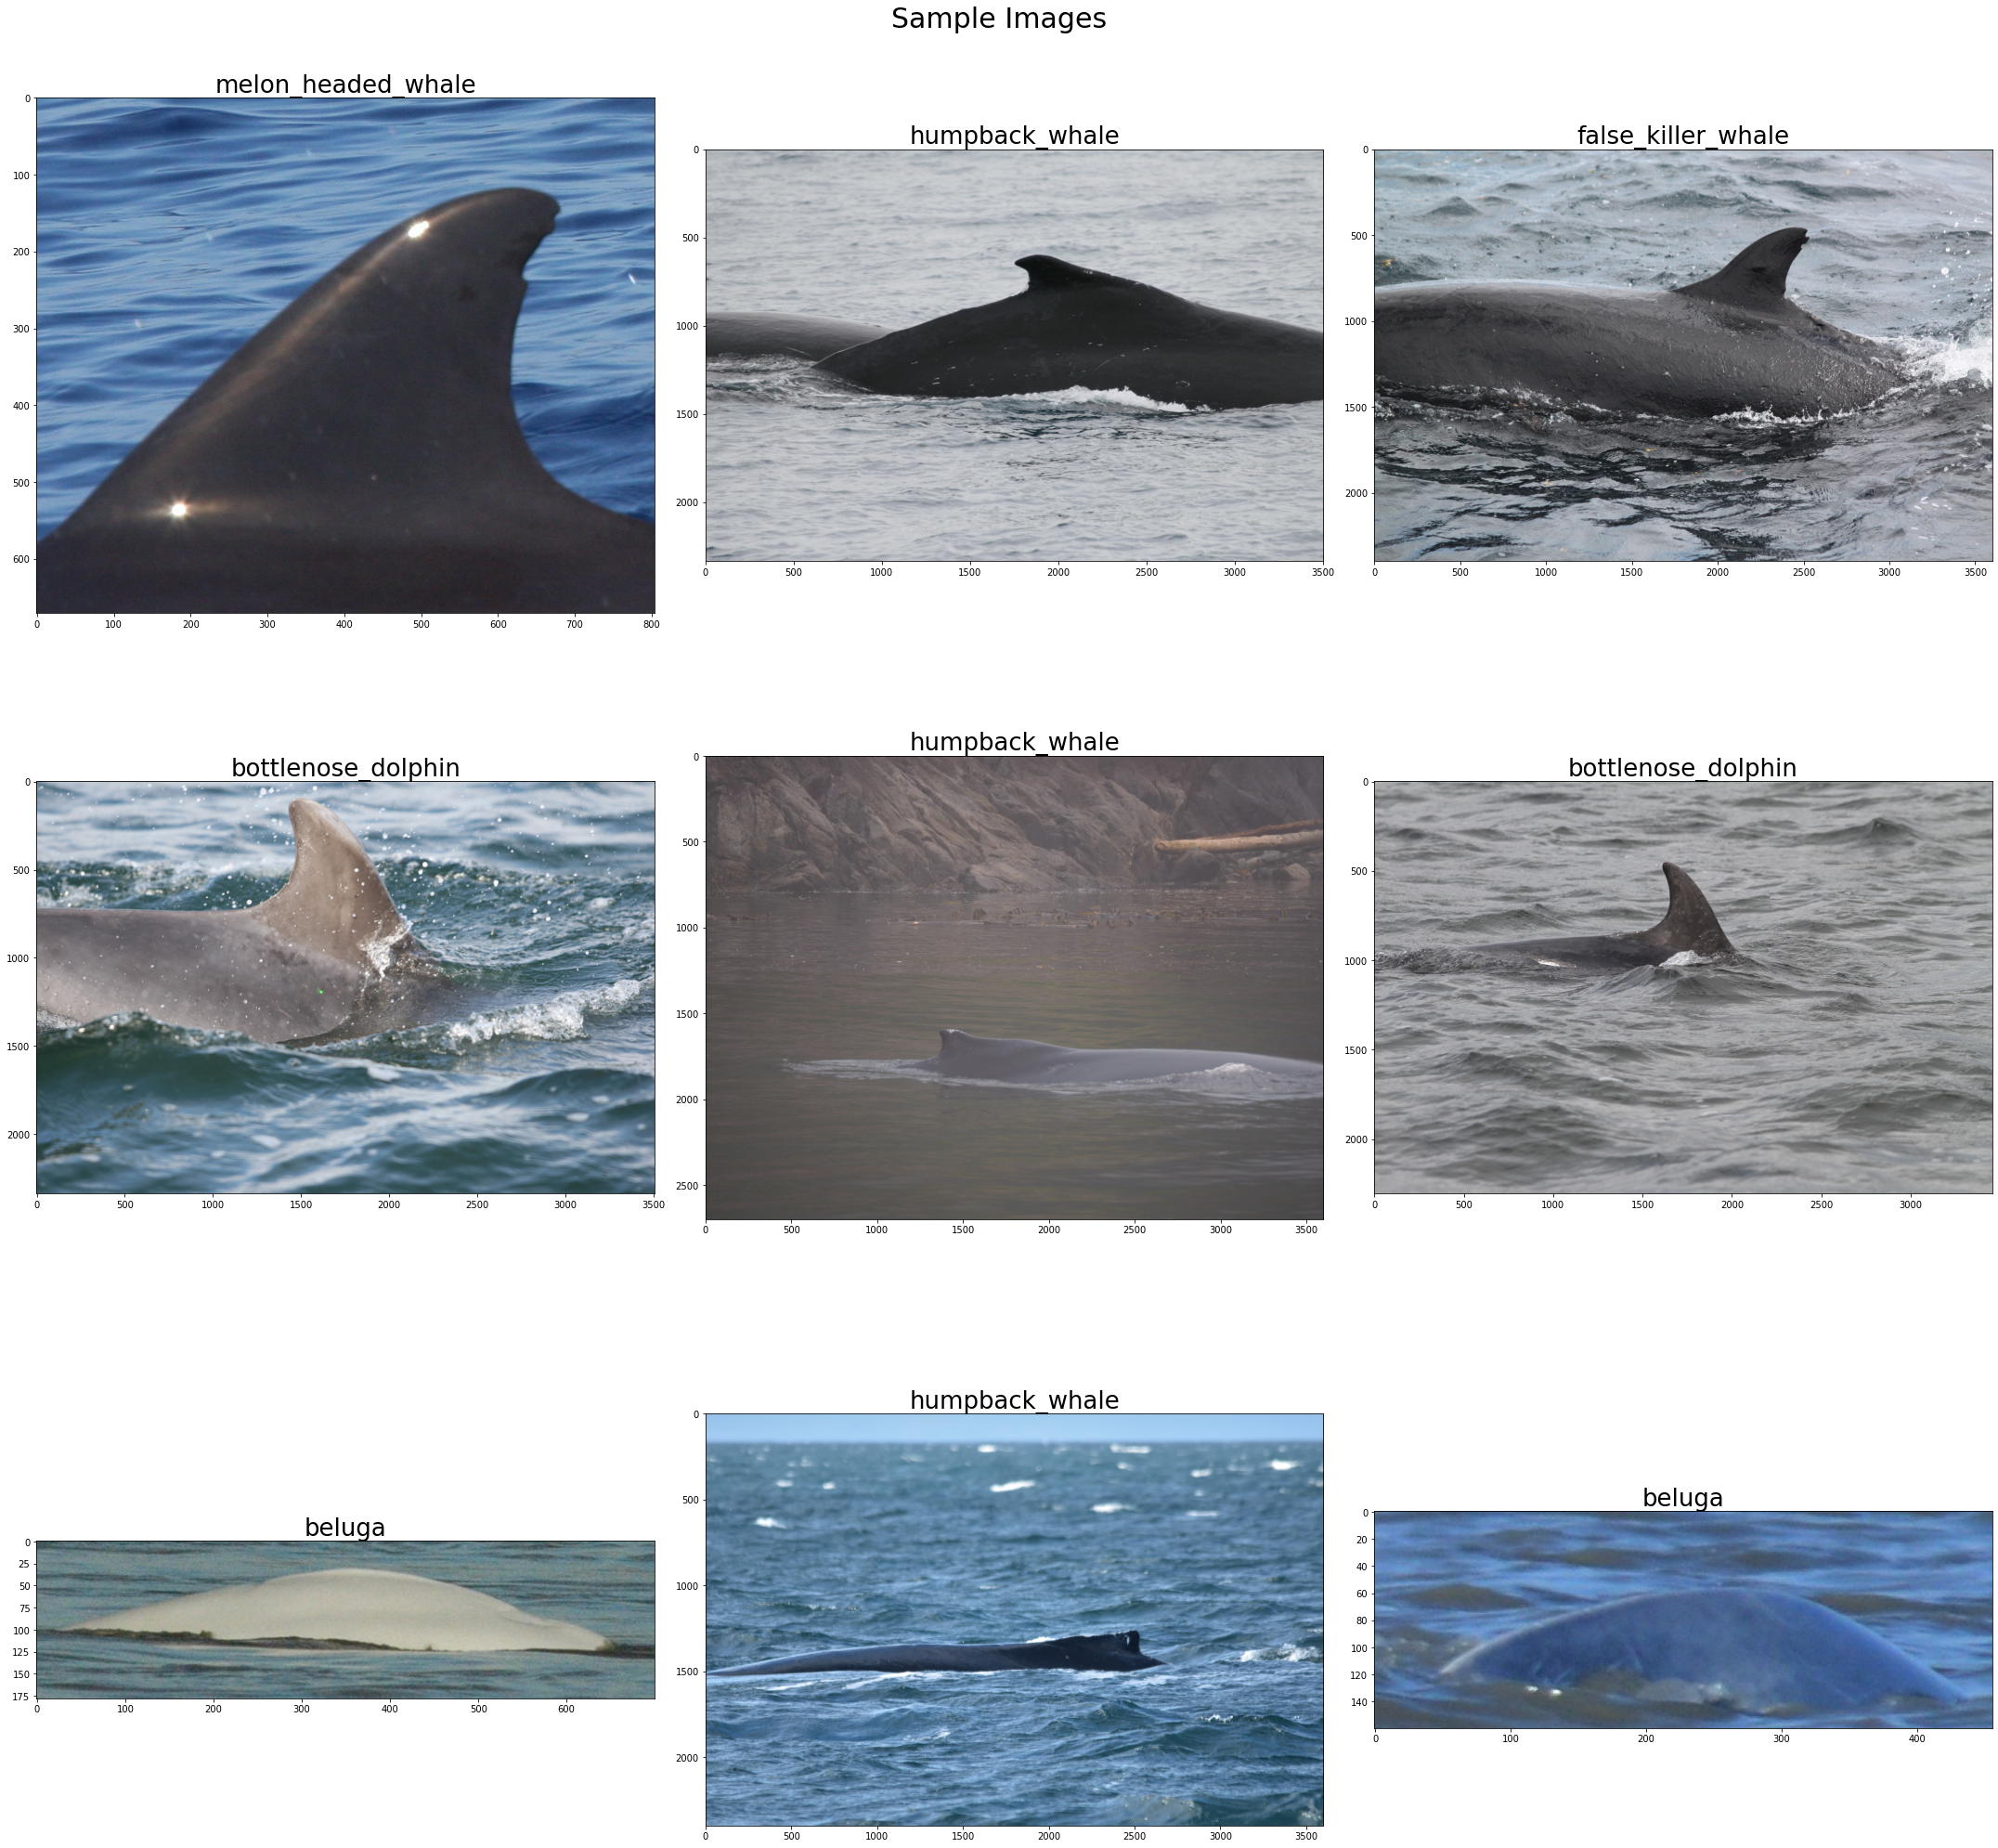

In [25]:
sample_img(train_df)

### Data Generation with Argumentation

In [26]:
train_dir = "../input/happy-whale-and-dolphin/train_images"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.3,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    fill_mode="wrap",
    brightness_range=(.5, 1.5),
    validation_split = 0.2,
    horizontal_flip = True)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(.5, 1.5),
    validation_split = 0.2)

train_set = train_datagen.flow_from_dataframe(
    train_df, train_dir,
    seed = 123,
    target_size = (64,64),
    batch_size = 32,
    x_col='image',
    y_col='individual_id',
    class_mode = 'categorical',
    subset = 'training')

valid_set = valid_datagen.flow_from_dataframe(
    train_df, 
    train_dir,
    seed = 123,
    target_size = (64,64),
    x_col='image',
    y_col='individual_id',
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation')

Found 40827 validated image filenames belonging to 15587 classes.
Found 10206 validated image filenames belonging to 15587 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_dir = '../input/happy-whale-and-dolphin/test_images'

test_set = test_datagen.flow_from_dataframe(
    test_df,
    test_dir,
    x_col='image_ids',
    y_col=None,
    seed = 123,
    batch_size = 32,
    class_mode=None,
    target_size = (64,64)                           
)

In [30]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    
    plt.figure(figsize=(20, 20))
    r=len(labels) if len(labels)<25 else 25

    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i]       
        plt.imshow(image)
        
        index=np.argmax(labels[i])
        class_name=classes[index]
        
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
        
    plt.show()

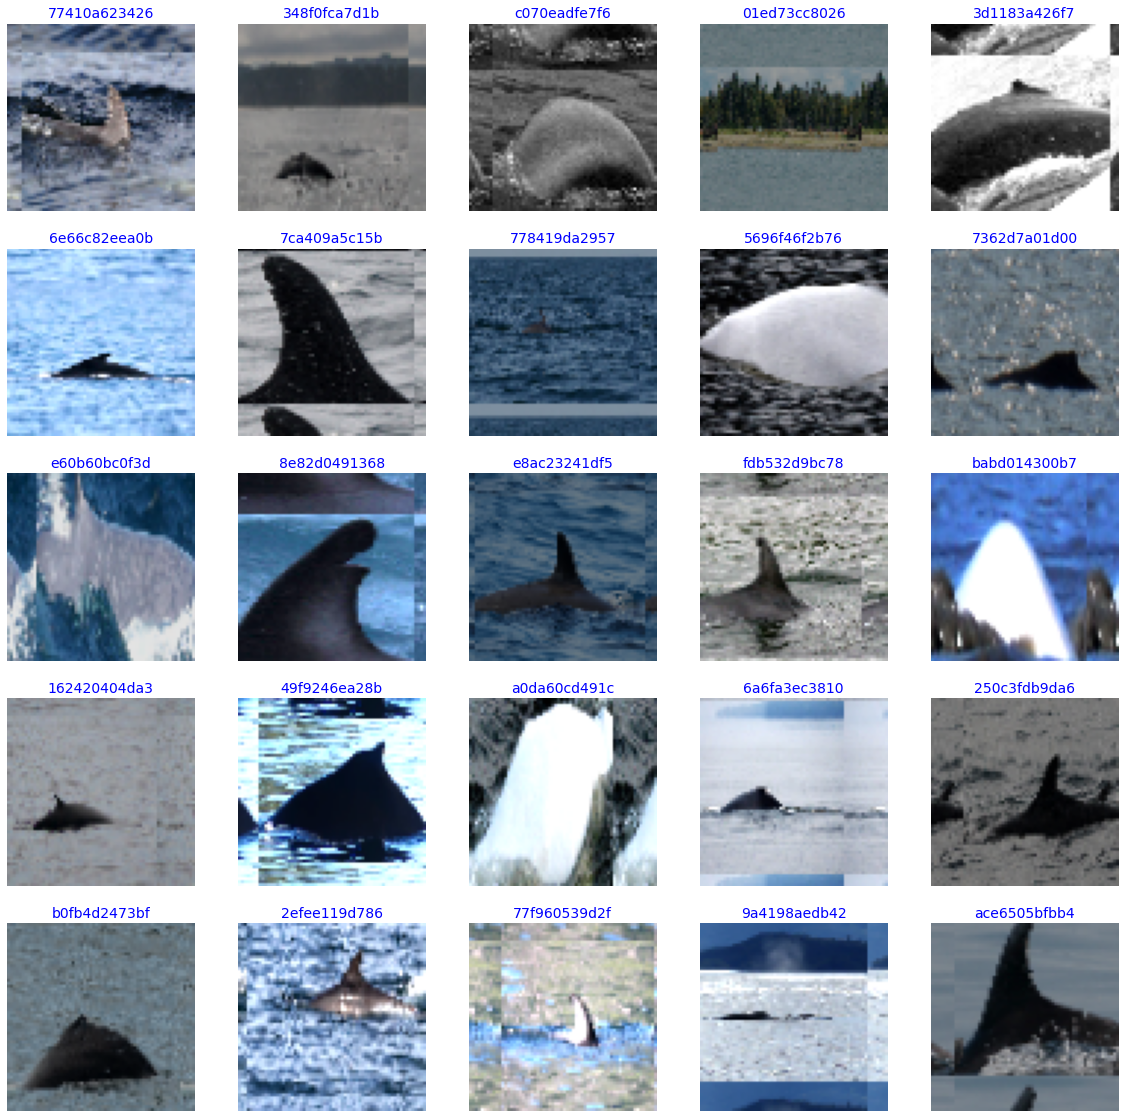

In [31]:
show_image_samples(train_set)

### Building a CNN Model

In [ ]:
# CNN architecture
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(15587, activation='softmax'))

### Model Summary

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer="adamax",
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.Precision(top_k=5)]
)

reduceLROnPlateau = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

### Predicting Individuals

In [ ]:
# get loss and accuracy
eval_dict_valid = model.evaluate(x=valid_set, return_dict=True)
print(*eval_dict_valid.items(), sep='\n')

In [ ]:
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = valid_set.n//valid_set.batch_size
STEP_SIZE_TEST = test_set.n//test_set.batch_size

history = model.fit(
    train_set,
    callbacks=[reduceLROnPlateau],
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_set,
    validation_steps=STEP_SIZE_VALID,
    epochs=5
)